# Quantile Regression

*Author: Evan Carey*

*Copyright 2017, BH Analytics, LLC*

## Overview

The purpose of this section is to cover quantile regression in the context of Python, specifically the statsmodels module. We will first think about why we might use quantile regression, then implement some models. 

## Libraries

In [1]:
## Import Modules
import os
import sys
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from patsy import dmatrices
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels
import seaborn as sns
import textwrap

In [2]:
## Enable inline plotting for graphics
%matplotlib inline

## Set print options
pd.options.display.max_rows = 10

In [3]:
print(textwrap.fill(sys.version),'\n')
print("Pandas version: {0}".format(pd.__version__),'\n')
print("Matplotlib version: {0}".format(matplotlib.__version__),'\n')
print("Numpy version: {0}".format(np.__version__),'\n')
print("Statsmodels version: {0}".format(statsmodels.__version__))

3.6.0 |Anaconda custom (64-bit)| (default, Dec 23 2016, 11:57:41) [MSC
v.1900 64 bit (AMD64)] 

Pandas version: 0.19.2 

Matplotlib version: 2.0.0 

Numpy version: 1.11.3 

Statsmodels version: 0.6.1


## Check your working directory

Subsequent sessions may require you to identify and update your working directory so paths correctly point at the downloaded data files. You can check your working directory like so:

In [4]:
# Working Directory
import os
print("My working directory:\n" + os.getcwd())
# Set Working Directory (if needed)
os.chdir(r"J:\Sync\Work\BHAnalytics\Python")
print("My new working directory:\n" + os.getcwd())

My working directory:
J:\Sync\Work\BHAnalytics\Python\01_Current_Python\notebooks
My new working directory:
J:\Sync\Work\BHAnalytics\Python


## Motivating Example: Sales data

For this section, we will use some sales data as a motivating example. This is a simulated dataset with both a binary outcome (sale) and a continuous outcome (sale_amount). We will focus on a subset of the data with positive sale amounts. First, we should import the data. 

In [5]:
## import data
sale_df = pd.read_csv(r'data\Simulated_sales_data_2\customer_sales1.csv')

In [6]:
sale_df

customer_id sale  sale_amount  region  age  gender activity  \
0          100000   No     0.000000      35   62    Male      Med   
1          100001  Yes   884.478029      13   71  Female     High   
2          100002   No     0.000000      23   53    Male     High   
3          100003   No     0.000000      12   60    Male      Med   
4          100004  Yes   243.937661      44   62    Male      Med   
...           ...  ...          ...     ...  ...     ...      ...   
7995       109995   No     0.000000       5   57    Male      Low   
7996       109996  Yes   722.514200      20   75  Female     High   
7997       109997  Yes   136.011300      11   58    Male      Low   
7998       109998  Yes   357.461500      49   64    Male      Med   
7999       109999  Yes    19.834360      30   46    Male      Med   

      marketing_exposure         x1         x2          x3  x4  x5  \
0                      6  73.674643   8.263063   93.879407  10   1   
1                      5  49.195984  11.925201   72.862514   7   2   
2                      6  49.868492  10.932390  128.150580  12   2   
3                      7  42.563154   9.725310  126.266391  11   1   
4                     11  45.035440   9.941171  108.037634   9   3   
...                  ...        ...        ...         ...  ..  ..   
7995                   4  70.116000  10.037210   87.654960  13   0   
7996                   1  38.415910  14.850920  129.327200  12   1   
7997                   6  49.014800  10.558640   97.097510  15   2   
7998                   7  52.215140   8.967199   59.178810  11   0   
7999                   4  21.092390   9.611086  106.878500   9   5   

      num_accounts current_customer  income  
0                0               No      78  
1                2               No      66  
2                1              Yes      86  
3                0              Yes      70  
4                0               No      59  
...            ...              ...     ...  
7995             1               No      59  
7996             0               No      74  
7997             0              Yes      54  
7998             0              Yes      59  
7999             0              Yes      59  

[8000 rows x 16 columns]

In [7]:
## Subset down to only the rows with sales
sub_sale_df = sale_df.loc[sale_df.sale_amount>0,].copy()

In [8]:
print(sub_sale_df.describe())

         customer_id  sale_amount       region          age  \
count    4765.000000  4765.000000  4765.000000  4765.000000   
mean   104998.994963   418.010294    25.786779    60.136831   
std      2899.603126   308.548414    14.122540    11.175953   
min    100001.000000    10.000000     1.000000    21.000000   
25%    102446.000000   185.226800    14.000000    53.000000   
50%    104991.000000   357.894854    26.000000    60.000000   
75%    107498.000000   582.188400    38.000000    68.000000   
max    109999.000000  2111.991000    50.000000    98.000000   

       marketing_exposure           x1           x2           x3           x4  \
count         4765.000000  4765.000000  4765.000000  4765.000000  4765.000000   
mean             4.706401    49.926427     9.951681   102.195231     9.968730   
std              2.584599    10.117197     2.024681    19.519291     3.082423   
min              0.000000    14.596822     2.598669    31.452700     2.000000   
25%              3.000000  

## Examine the Distribution of the Outcome

We can start by looking at the distribution of the outcome to get a sense of the data.

C:\Users\evan\Miniconda3\envs\py3ds\lib\site-packages\statsmodels\nonparametric\kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


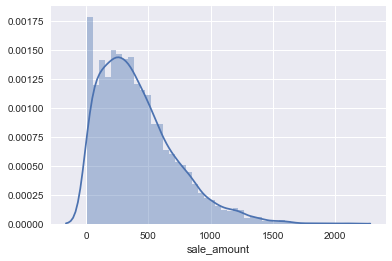

In [9]:
sns.distplot(sub_sale_df.sale_amount)

This looks like a typical strictly positive distribution. Since it is not possible to have a negative sale price, we see a bit of skew, with most of the data focused on lower priced items, and a smaller amount of data in the higher priced items. 

Although it would be reasonable to use linear regression in this problem, we may decide to implement quantile regression if we desire to make inference on the median, or perhaps the 75 percentile, rather than the mean. In that case, we must use quantile regression. Quantile regression works very similarly to linear regression in practice using Python, however, the underlying optimization is different. We will make inference on the 75 percentile for this exercise, but you could choose any percentile. 

In [10]:
sub_sale_df.sale_amount.quantile([0.75])

0.75    582.1884
Name: sale_amount, dtype: float64

In [11]:
mod0 = smf.quantreg('sale_amount ~ 1',
                    data=sub_sale_df).fit(q=0.75)
print(mod0.summary())

                         QuantReg Regression Results                          
Dep. Variable:            sale_amount   Pseudo R-squared:                0.000
Model:                       QuantReg   Bandwidth:                       74.94
Method:                 Least Squares   Sparsity:                        1211.
Date:                Sun, 23 Apr 2017   No. Observations:                 4765
Time:                        17:20:45   Df Residuals:                     4764
                                        Df Model:                            0
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept    582.1884      7.598     76.626      0.000       567.293   597.084


## Age by Sale Amount

We can investigate the relationship between age and the 75 percentile of sale amount. If we simply include age in the model as a linear predictor, we are assuming a linear relationship between these variables. Is that appropriate here?

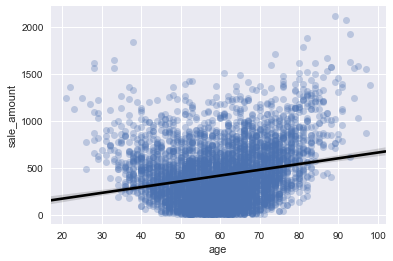

In [12]:
sns.regplot(x='age',
            y='sale_amount',
            data=sub_sale_df,
            scatter_kws={'alpha':0.3},
            line_kws={'color': 'black'})

It looks like there is a non-linear relationship between age and the sale amount. In this case, we may be able to approximate it using a simply polynomial like this:

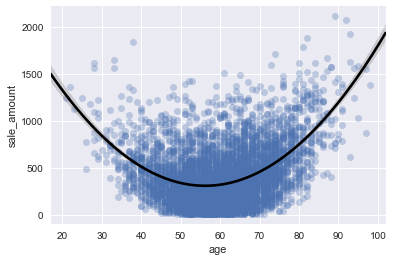

In [13]:
sns.regplot(x='age',
            y='sale_amount',
            data=sub_sale_df,
            scatter_kws={'alpha':0.3},
            line_kws={'color': 'black'},
            order=2)

This looks like a good fit to the data. We can fit this in the linear model like so:

In [14]:
mod1 = smf.quantreg('sale_amount ~ age + I(age**2)',
                    data=sub_sale_df).fit(q=0.75)
print(mod1.summary())

                         QuantReg Regression Results                          
Dep. Variable:            sale_amount   Pseudo R-squared:               0.1389
Model:                       QuantReg   Bandwidth:                       65.38
Method:                 Least Squares   Sparsity:                        1012.
Date:                Sun, 23 Apr 2017   No. Observations:                 4765
Time:                        17:20:46   Df Residuals:                     4762
                                        Df Model:                            2
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    3037.6825    132.134     22.989      0.000      2778.638  3296.727
age           -93.9645      4.411    -21.303      0.000      -102.612   -85.317
I(age ** 2)     0.8499      0.036     23.456      0.000         0.779     0.921

The condition number is large, 8.23e+04. This 

C:\Users\evan\Miniconda3\envs\py3ds\lib\site-packages\statsmodels\regression\quantile_regression.py:189: ConvergenceWarning: Convergence cycle detected
  warnings.warn("Convergence cycle detected", ConvergenceWarning)


We are seeing some convergence issue with this model. This indicates we may be unable to get the model to converge with a polynomial term for age. Interestingly, this is not true for the median:

In [15]:
mod1 = smf.quantreg('sale_amount ~ age + I(age**2)',
                    data=sub_sale_df).fit(q=0.5)
print(mod1.summary())

                         QuantReg Regression Results                          
Dep. Variable:            sale_amount   Pseudo R-squared:               0.1234
Model:                       QuantReg   Bandwidth:                       75.95
Method:                 Least Squares   Sparsity:                        667.8
Date:                Sun, 23 Apr 2017   No. Observations:                 4765
Time:                        17:20:46   Df Residuals:                     4762
                                        Df Model:                            2
                  coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------
Intercept    2817.0347    100.022     28.164      0.000      2620.945  3013.125
age           -91.1809      3.351    -27.213      0.000       -97.750   -84.612
I(age ** 2)     0.8125      0.028     29.413      0.000         0.758     0.867

The condition number is large, 8.23e+04. This 

The model with the median converged without warning, and gave similar results. I might trust the original model of the 75 percentile, even though there were convergence warnings. 

## Non-Linearity: Marketing Exposure

We may also be interested in estimating the effect of marketing exposure on the sale amount. Let's begin by visualizing the relationship between these variables alone:

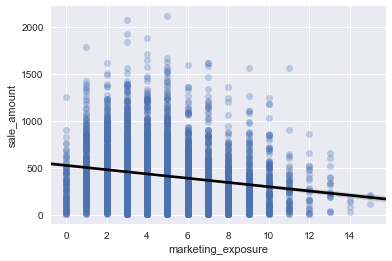

In [16]:
sns.regplot(x='marketing_exposure',
            y='sale_amount',
            data=sub_sale_df,
            scatter_kws={'alpha':0.3},
            line_kws={'color': 'black'})

It looks like there is an overall negative effect of marketing exposure! The more marketing exposure someone recieves, the less likely they are to buy the product?!? We will find this is not the case in the end, but let's continue with this pairwise investigation for now. 

In [17]:
mod2 = smf.quantreg('sale_amount ~ marketing_exposure',
                    data=sub_sale_df).fit(q=0.75)
print(mod2.summary())

                         QuantReg Regression Results                          
Dep. Variable:            sale_amount   Pseudo R-squared:              0.02374
Model:                       QuantReg   Bandwidth:                       73.04
Method:                 Least Squares   Sparsity:                        1153.
Date:                Sun, 23 Apr 2017   No. Observations:                 4765
Time:                        17:20:47   Df Residuals:                     4763
                                        Df Model:                            1
                         coef    std err          t      P>|t|      [95.0% Conf. Int.]
--------------------------------------------------------------------------------------
Intercept            721.3397     14.813     48.696      0.000       692.299   750.380
marketing_exposure   -29.7228      2.747    -10.821      0.000       -35.108   -24.338


## Non-Linearity: Splines and Marketing Exposure

We can further examine this relationship by looking at a non-linear fit for this data. 

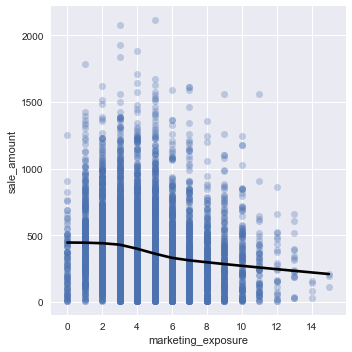

In [18]:
sns.lmplot(x='marketing_exposure',
           y='sale_amount',
           data=sub_sale_df,
           scatter_kws={'alpha':0.3},
           line_kws={'color': 'black'},
           lowess=True)

The non-linear fit gives us a similar answer as the linear fit. We can fit a flexible line in the context of regression by using splines. The general idea is that we split the data up into regions, then fit a polynomial within each region that connects. It is pretty straightforward to fit a spline model using statsmodels and patsy, but the output can be difficult to understand. We need to define the number of knots (the place we will split intp different regions). We do this by defining the degress of freedom. 

In [19]:
mod3= smf.quantreg('sale_amount ~ bs(marketing_exposure,3)',
                   data=sub_sale_df).fit(q=0.75)
print(mod3.summary())

                         QuantReg Regression Results                          
Dep. Variable:            sale_amount   Pseudo R-squared:              0.02834
Model:                       QuantReg   Bandwidth:                       73.62
Method:                 Least Squares   Sparsity:                        1155.
Date:                Sun, 23 Apr 2017   No. Observations:                 4765
Time:                        17:20:47   Df Residuals:                     4761
                                        Df Model:                            3
                                   coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------------------------
Intercept                      550.3952     30.515     18.037      0.000       490.571   610.219
bs(marketing_exposure, 3)[0]   449.1038     95.703      4.693      0.000       261.482   636.726
bs(marketing_exposure, 3)[1]  -696.5940     94.520     -7.3

We can visualize the spline we just fit by running some predictions through the model like so:

In [20]:
df_temp = pd.DataFrame({'marketing_exposure':np.arange(14)})
df_temp['pred_sale_amount'] = mod3.predict(df_temp)

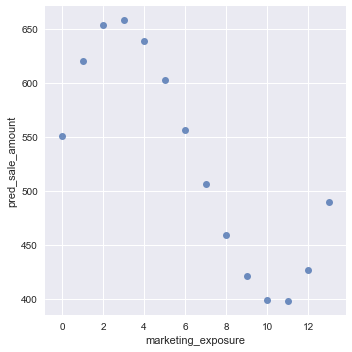

In [21]:
sns.lmplot(x='marketing_exposure',
           y='pred_sale_amount',
           data=df_temp,
           fit_reg=False)

We can specify the degree of the polynomials used, by saying degree == 1, we are asking for straight lines in each region. 

In [22]:
mod4 = smf.quantreg('sale_amount ~ bs(marketing_exposure,3,degree=1)',
                    data=sub_sale_df).fit(q=0.75)
print(mod4.summary())

                         QuantReg Regression Results                          
Dep. Variable:            sale_amount   Pseudo R-squared:              0.02975
Model:                       QuantReg   Bandwidth:                       72.08
Method:                 Least Squares   Sparsity:                        1134.
Date:                Sun, 23 Apr 2017   No. Observations:                 4765
Time:                        17:20:47   Df Residuals:                     4761
                                        Df Model:                            3
                                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------------
Intercept                                566.6028     28.815     19.663      0.000       510.111   623.094
bs(marketing_exposure, 3, degree=1)[0]   122.6714     35.237      3.481      0.001        53.591   191.752
bs(marketing_exposu

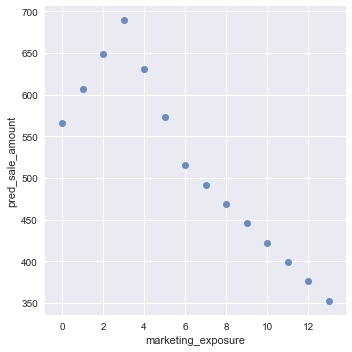

In [23]:
df_temp = pd.DataFrame({'marketing_exposure':np.arange(14)})
df_temp['pred_sale_amount'] = mod4.predict(df_temp)
sns.lmplot(x='marketing_exposure',
           y='pred_sale_amount',
           data=df_temp,
           fit_reg=False)

## Interaction Effects: Gender by Marketing Exposure

This is an odd relationship...the more marketing exposure, the less sale amount? Perhaps there is something else going on here. Gender may also play a role...let's examine the relationship between marketing exposure and sale amount for each gender seperately. 

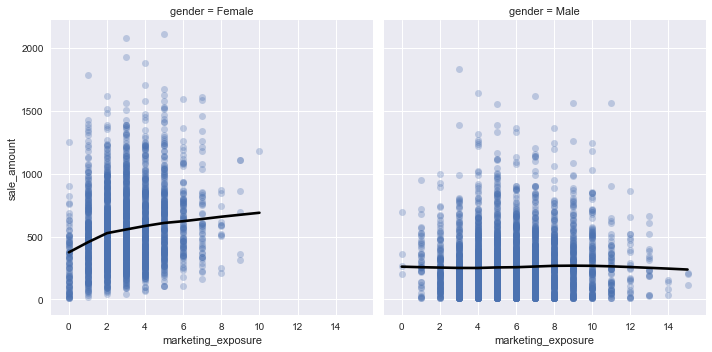

In [24]:
sns.lmplot(x='marketing_exposure',
           y='sale_amount',
           data=sub_sale_df,
           scatter_kws={'alpha':0.3},
           line_kws={'color': 'black'},
           lowess=True,
          col='gender')


This result looks very different than what we just found! We are seeing that there is a positive effect of marketing exposure in females that seems to plateau...but there is no effect in males. This is plausible, but how would we fit this in our model? We do this by including an interaction term between these variables. The interacton term is denoted by the * sign. It is a literal multiplication of the two terms together. We will start by adding gender into the model, then also adding the interaction so we have a comparison. 

In [25]:
## Add gender into the model, no interaction yet
mod5 = smf.quantreg('sale_amount ~ bs(marketing_exposure,3,degree=1) + gender',
                    data=sub_sale_df).fit(q=0.75)
print(mod5.summary())

                         QuantReg Regression Results                          
Dep. Variable:            sale_amount   Pseudo R-squared:               0.1368
Model:                       QuantReg   Bandwidth:                       62.82
Method:                 Least Squares   Sparsity:                        1021.
Date:                Sun, 23 Apr 2017   No. Observations:                 4765
Time:                        17:20:48   Df Residuals:                     4760
                                        Df Model:                            4
                                             coef    std err          t      P>|t|      [95.0% Conf. Int.]
----------------------------------------------------------------------------------------------------------
Intercept                                628.3060     26.214     23.968      0.000       576.915   679.697
gender[T.Male]                          -373.6942     16.238    -23.014      0.000      -405.528  -341.860
bs(marketing_exposu

In [26]:
## Add gender into the model with interaction 
mod6 = smf.quantreg('sale_amount ~ bs(marketing_exposure,3,degree=2) * gender',
                    data=sub_sale_df).fit(q=0.75)
print(mod6.summary())

                         QuantReg Regression Results                          
Dep. Variable:            sale_amount   Pseudo R-squared:               0.1411
Model:                       QuantReg   Bandwidth:                       62.19
Method:                 Least Squares   Sparsity:                        1007.
Date:                Sun, 23 Apr 2017   No. Observations:                 4765
Time:                        17:20:48   Df Residuals:                     4757
                                        Df Model:                            7
                                                            coef    std err          t      P>|t|      [95.0% Conf. Int.]
-------------------------------------------------------------------------------------------------------------------------
Intercept                                               501.9200     34.958     14.358      0.000       433.385   570.455
gender[T.Male]                                           -6.1061    104.029     -

## Understanding the Interaction and Spline Terms

If we want to really understand the spline term interaction we just fit, we must again make some predictions to visualize the result of the model terms. 

In [27]:
df_temp = pd.DataFrame({'marketing_exposure':list(range(14))*2,
                        'gender':['Male']*14 + ['Female']*14})

In [28]:
df_temp

gender  marketing_exposure
0     Male                   0
1     Male                   1
2     Male                   2
3     Male                   3
4     Male                   4
..     ...                 ...
23  Female                   9
24  Female                  10
25  Female                  11
26  Female                  12
27  Female                  13

[28 rows x 2 columns]

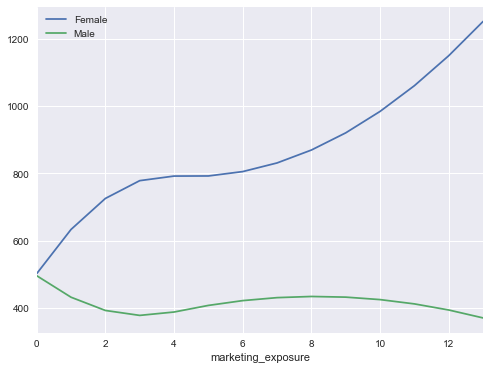

In [29]:
df_temp['pred_sale_amount'] = mod6.predict(df_temp)
fig, ax = plt.subplots(figsize=(8,6))
for label, df in df_temp.groupby('gender'):
    df.plot(x='marketing_exposure',y='pred_sale_amount',ax=ax, label=label)
plt.legend()